# Faster than the clock algorithms

Faster than the clock algorithms are useful in cases when the acceptance rate of the standard Monte Carlo is low. An example of this is the Ising model at low temperatures, when we are disregarding most of the moves. The idea of the faster than the clock algorithms is to speed up the simulation by calculating the probability distribution of the number of moves that will be required in order to change the state of the system. Then, only accepted moves need to be evaluated during the simulation. One just has to properly generate the times between two of these accepted moves.

## Random depositions

Let's consider the problem of random depositions in one dimension. Consider the line of length $L$ on which we are randomly depositing  pins of width $2 \times \sigma$ on the interval $[\sigma,L-\sigma]$ which cannot overlap. At time $t=1$ we deposit the first pin and in succesive time steps we try to deposite further pins. We make the deposition if the move is allowed, otherwise we choose a new position etc. The process halts when no further pins can be deposited.

<br>
<table><tr style="background-color: white;">
<td> <img src="https://gist.github.com/mferrero/ae328ab0e3a0d3d7181a007daf5a373a/raw/clothes_pins_many.png" width=500 height=150 /> </td>
<td> <img src="https://gist.github.com/mferrero/ae328ab0e3a0d3d7181a007daf5a373a/raw/clothes_pins_single.png" width=200 height=150 /> </td>
</tr></table>
<br>

In the following, we will write two Monte Carlo algorithms to simulate random depositions, a direct real-time implementation and a faster than the clock implementation. Results will be compared with the analytical solution.

We first import the necessary libraries

In [2]:
import numpy as np
import bisect
import matplotlib.pylab as plt

## Real time algorithm

Write the random depositions algorithm in real time, which outputs the times at which the depositions are made.
You can use pins with $\sigma = 1$. Start with $L = 100$ and increase to $L = 10000$ to see how the
simulation time changes.

Hint: It is a good idea to encode the positions of the pins in an *ordered* list. You can then use bisection to quickly find where a new pin has to be inserted. This example shows how to use the `bisect` function
```python
pins = [1, 4, 6, 7, 10, 16]
ind = bisect.bisect(pins, 9) # find where 9 would go
pins.insert(ind, 9) # insert 9 in the right place
print(pins)
```

In [3]:
L=100
sigma=1
occupied=[-sigma, L+sigma]

condition=True
j=0
times=[]
while (condition==True):
    j+=1
    proposal = np.random.uniform(0,L)
    prop_indx = bisect.bisect(occupied, proposal)
    closest = np.array([occupied[prop_indx-1], occupied[prop_indx]])
    empty = np.all(np.abs(closest-proposal)>2)
    distances= np.abs(np.array(occupied)-proposal)
    if empty == min(distances) > 2:
        ind= bisect.bisect(occupied, proposal)
        occupied.insert(ind, proposal)
        times.append(j)
    if max(distances) < 2 : break
print(times)

Text(0.5, 0, 'pins position')

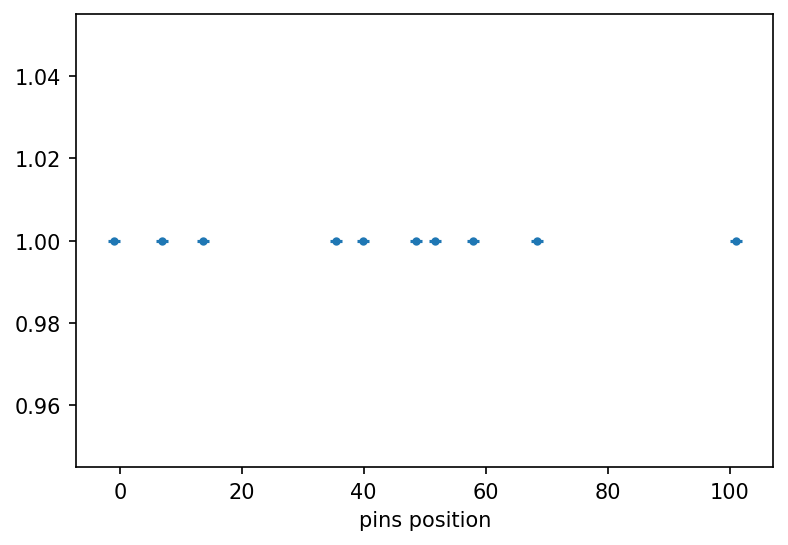

In [65]:
plt.figure(dpi=150)
plt.errorbar(occupied, np.ones(len(occupied)), xerr=np.ones(len(occupied)), fmt=".")
plt.xlabel("pins position")

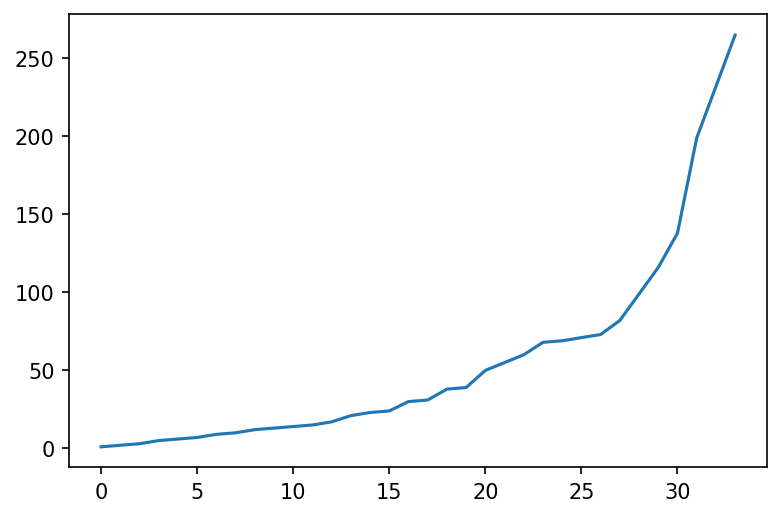

In [47]:
plt.figure(dpi=150)
plt.plot(times)

## Faster than the clock algorithm

As you must have seen, the real-time implementation of the algorithm can become very slow. Indeed,
the probability to place the pins at the right places when there is not so much space left becomes
very small. As a result, the simulation times can become very long. We will now see how this can
be avoided by implementing a faster than the clock algorithm. Here are the steps:

- Given a certain configuration of pins, make a list of all the intervals where new pins can
  be inserted.
  
- From the cumulative length of all these intervals, you can easily deduce the probability that the
  next trial insertion will be accepted. You then also know the probability $p_r$ that this trial
  will be rejected.

- The distribution of the number of steps $t$ until a proposal is accepted is given by

  $$
  \pi(t) = p_r^{t-1} (1 - p_r)
  $$
  
  This distribution can be sampled from a uniform random variable $\xi \in [0,1]$ with
  
  $$
  t = 1 + \left\lfloor \frac{\log(\xi)}{\log(p_r)} \right\rfloor
  $$

  With the knowledge of $p_r$ you can generate a faster than the clock time until the next
  accepted proposal.
  
- Produce a new configuration of pins by randomly choosing a valid position for the new pin.
  Be careful to pick this position uniformly across all valid intervals that you have found above.
  
- Keep track of the times when pins were inserted.

Hint: It is a good idea to construct the list of intervals by specifying both their length and the position on the line where they start. This will be useful to more easily find the place where the next pin will be inserted.

In [ ]:
# parameters
sigma = 1
L = 100
np.random.seed(9827)

# initialize variables
pins = [-sigma, L+sigma] # two fake pins
time = 0

# main loop
while(True):
    
    time += 1
    #r = np.random.uniform(sigma, L-sigma)
    #ind = bisect.bisect(pins, r)
    
    # distance to neighbors
    dist_r = pins[ind] - r
    dist_l = r - pins[ind-1]
    
    # there is enough space
    if dist_r >= 2*sigma and dist_l >= 2*sigma:

        # insert pin
        pins.insert(ind, r)

        # is there still some space somewhere?
        pin_array = np.array(pins)
        n = len(pins)
        intervals = pin_array[1:n] - pin_array[0:n-1]
        available = np.any(intervals > 4 * sigma)
        n_available = np.sum(intervals > 4 * sigma)
        
        print("time = ", time, "# pins = ", n-2, "# available = ", n_available)
        
        # stop if no space left
        if not available: break
        
            
print("Density = ", (len(pins)-2) * 2 * sigma / L)

## Comparison with analytical solution

It can be shown that the distribution of the density of pins as a function of
time is given by

$$
\rho(T) = \int_0^T  du\;\exp\left\{-2\int_{0}^u\frac{dv}{v}(1-e^{-v})\right\}
$$

where $T = 2\sigma t/L$ is a renormalized simulation time. Check if the faster than
the clock algorithm has produced densities in time that are compatible with this
formula. You can use this code to produce the analytical data:

```python
from scipy.integrate import quad

F = lambda u: quad(lambda v: (1 - np.exp(-v)) / v, 0, u)[0]
analytic = lambda T: quad(lambda u: np.exp(-2 * F(u)), 0, T)[0]
x_data = np.logspace(-4, 4, 50)
y_data = np.vectorize(analytic)(x_data)
```

## References

* Rényi, A. "On a One-Dimensional Problem Concerning Random Space-Filling." Publ. Math. Inst. Hung. Acad. Sci. 3, 109-127, 1958 
* Y. Pomeau, Some asymptotic estimates in the random parking problem, J. Phys. A: Math. Gen. 13 L193 (1980)
* V. Privman, J.-S. Wang, and P. Nielaba, Continuum limit in random sequential adsorption, Phys. Rev. B 43 3366 (1991)